In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML("<style> div.output_area pre { white-space: pre; } </style>"))
display(HTML("<style> .container { width:90% !important; } </style>"))
display(HTML("<style> .output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style> div.output_stderr { display: none; } </style>")) # suppress warning

/var/folders/m2/gjg_80ys4rsb6_zzf8mpl27r0000gn/T/ipykernel_2718/1217205904.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
import describe as describe

In [ ]:
%run -i model_function.ipynb


# Data Import and Validation


In [4]:
train = pd.read_csv('train.csv').drop(columns=['Unnamed: 0'])
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

## Map between item_id and category_id

In [5]:
validate_df = train.merge(items.rename(columns={'item_category_id': 'category_infer'}), on='item_id')
validate_df[validate_df['item_category_id']!=validate_df['category_infer']]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category_infer


# Items

In [6]:
describe.data_overview(items,return_raw=True)

,#,total,dtype,#distinct,distinct (%),#null,#zero,#negative,#empty,null (%),zero (%),negative (%),empty (%),hit_rate
item_id,1,"22,170",int64,"22,170",100.00%,-,1,-,-,-,-,-,-,100.00%
item_category_id,2,"22,170",int64,84,-,-,4,-,-,-,-,-,-,100.00%


In [7]:
item_cate = (
            items.groupby('item_id')['item_category_id'].nunique()
             .rename('nof_cate')
             .reset_index()
            )
describe.describe_1d_category_with_plot(item_cate, 'nof_cate')


nof_cate,count,frequency (%)
1,"22,170",100.00%
Total,"22,170",100.00%


In [8]:
item_cate = (
            items.groupby('item_category_id')['item_id'].nunique()
             .rename('nof_items')
             .reset_index()
            )
describe.describe_1d_numeric_with_plot(item_cate, 'nof_items')


stat,value,percentile,value
count,84,1%,1.00
non_null,84,5%,2.15
null,0.00%,10%,4.00
min,1.00,20%,6.60
max,"5,035.00",30%,11.70
mode,6.00,40%,20.80
mean,263.93,50%,43.50
tr_mean,206.45,60%,148.80
std,642.83,70%,229.20
mad,302.16,80%,323.00


In [9]:
item_cate[item_cate['nof_items'] >= 2500]

,item_category_id,nof_items
40,40,5035


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
items belong to high diversified category affect sales?

# Data for shop

In [10]:
shop = train[['shop_id', 'item_id']].drop_duplicates()

In [11]:
shop = shop.merge(test[['shop_id', 'item_id']], how='outer')

In [12]:
shop = shop.merge(items, how='left')

In [262]:
shop.to_csv('data/shop_details.csv',index=False)

In [13]:
describe.data_overview(shop,return_raw=True)

,#,total,dtype,#distinct,distinct (%),#null,#zero,#negative,#empty,null (%),zero (%),negative (%),empty (%),hit_rate
shop_id,1,"526,920",int64,60,-,-,"3,600",-,-,-,-,-,-,100.00%
item_id,2,"526,920",int64,"22,170",-,-,1,-,-,-,-,-,-,100.00%
item_category_id,3,"526,920",int64,84,-,-,45,-,-,-,-,-,-,100.00%


## Number of items/cate sold per shop

In [14]:
nof_item_per_shop = (
    shop.groupby('shop_id')['item_id'].nunique()
    .rename('nof_item_per_shop')
    .reset_index()
)
describe.describe_1d_numeric_with_plot(nof_item_per_shop, 'nof_item_per_shop')

stat,value,percentile,value
count,60,1%,592.25
non_null,60,5%,"1,374.65"
null,0.00%,10%,"2,461.60"
min,371.00,20%,"5,147.60"
max,"16,454.00",30%,"6,886.00"
mode,371.00,40%,"9,300.00"
mean,"8,782.00",50%,"9,907.50"
tr_mean,"8,794.74",60%,"10,337.60"
std,"3,919.39",70%,"10,866.30"
mad,"3,166.07",80%,"11,427.20"


In [15]:
nof_cate_per_shop = (
    shop.groupby('shop_id')['item_category_id'].nunique()
    .rename('nof_cate_per_shop')
    .reset_index()
)
describe.describe_1d_numeric_with_plot(nof_cate_per_shop, 'nof_cate_per_shop')

stat,value,percentile,value
count,60,1%,20.26
non_null,60,5%,37.85
null,0.00%,10%,42.80
min,12.00,20%,55.80
max,76.00,30%,61.40
mode,72.00,40%,69.60
mean,64.05,50%,72.00
tr_mean,64.93,60%,72.00
std,14.09,70%,72.30
mad,10.97,80%,73.20


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
each shop sold a huge variety of products

## Items sold by multiple shops??

In [16]:
nof_shop_per_item = (
    shop.groupby('item_id')['shop_id'].nunique()
    .rename('nof_shop_per_item')
    .reset_index()
)
describe.describe_1d_numeric_with_plot(nof_shop_per_item, 'nof_shop_per_item')

stat,value,percentile,value
count,"22,170",1%,1.00
non_null,"22,170",5%,1.00
null,0.00%,10%,1.00
min,1.00,20%,2.00
max,59.00,30%,7.00
mode,1.00,40%,13.00
mean,23.77,50%,22.00
tr_mean,23.60,60%,32.00
std,18.67,70%,42.00
mad,17.11,80%,44.00


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
80% of items were sold by more than 2 shops => May be a feature to check whether this affect number of product sold

In [151]:
nof_shop_per_item[nof_shop_per_item['nof_shop_per_item'] > 3]

,item_id,nof_shop_per_item
27,27,27
28,28,37
29,29,11
30,30,55
31,31,55
...,...,...
22163,22163,43
22164,22164,49
22166,22166,42
22167,22167,51


# Train data

In [17]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.00,37
1,03.01.2013,0,25,2552,899.00,1.00,58
2,05.01.2013,0,25,2552,899.00,-1.00,58
3,06.01.2013,0,25,2554,1709.05,1.00,58
4,15.01.2013,0,25,2555,1099.00,1.00,56


In [18]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [19]:
train['month'] = train['date'].dt.month

In [20]:
describe.data_overview(train,return_raw=True)

,#,total,dtype,#distinct,distinct (%),#null,#zero,#negative,#empty,null (%),zero (%),negative (%),empty (%),hit_rate
date,1,"2,935,849",datetime64[ns],"1,034",-,-,-,-,-,-,-,-,-,100.00%
date_block_num,2,"2,935,849",int64,34,-,-,"115,690",-,-,-,3.94%,-,-,100.00%
shop_id,3,"2,935,849",int64,60,-,-,"9,857",-,-,-,-,-,-,100.00%
item_id,4,"2,935,849",int64,"21,807",-,-,1,-,-,-,-,-,-,100.00%
item_price,5,"2,935,849",float64,"19,993",-,-,-,1,-,-,-,-,-,100.00%
item_cnt_day,6,"2,935,849",float64,198,-,-,-,"7,356",-,-,-,-,-,100.00%
item_category_id,7,"2,935,849",int64,84,-,-,3,-,-,-,-,-,-,100.00%
month,8,"2,935,849",int32,12,-,-,-,-,-,-,-,-,-,100.00%


## Why item_cnt_day has negative value ??? 
<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
Product return or Promotional Activities? 

In [21]:
describe.describe_1d_numeric_with_plot(train, 'item_cnt_day')

stat,value,percentile,value
count,"2,935,849",1%,1.00
non_null,"2,935,849",5%,1.00
null,0.00%,10%,1.00
min,-22.00,20%,1.00
max,"2,169.00",30%,1.00
mode,1.00,40%,1.00
mean,1.24,50%,1.00
tr_mean,1.13,60%,1.00
std,2.62,70%,1.00
mad,0.45,80%,1.00


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
To better perform our analysis, we gonna assume that -1 indicates product return 

## Datetime

In [22]:
tmp = train[['date']].astype('str')
describe.describe_1d_datetime_with_plot(tmp, 'date')

<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
The data shows a downward trend over time, with nof interactions increasing during the beginning and end of the year. This suggests that the month of the year could be a significant feature for the model.



## category distribution

In [23]:
describe.describe_1d_category_with_plot(train, 'item_category_id')

item_category_id,count,frequency (%)
40,"564,652",19.23%
30,"351,591",11.98%
55,"339,585",11.57%
19,"208,219",7.09%
37,"192,674",6.56%
23,"146,789",5.00%
28,"121,539",4.14%
20,"79,058",2.69%
63,"53,845",1.83%
Others,"877,897",29.90%


## Item distribution

In [24]:
train[['item_id', 'date']]

,item_id,date
0,22154,2013-01-02
1,2552,2013-01-03
2,2552,2013-01-05
3,2554,2013-01-06
4,2555,2013-01-15
...,...,...
2935844,7409,2015-10-10
2935845,7460,2015-10-09
2935846,7459,2015-10-14
2935847,7440,2015-10-22


## Item price distribution

In [25]:
price_per_item = train.groupby('item_id')[['item_price']].mean()
describe.describe_1d_numeric_with_plot(price_per_item, 'item_price')

stat,value,percentile,value
count,"21,807",1%,28.00
non_null,"21,807",5%,58.00
null,0.00%,10%,114.00
min,4.91,20%,149.00
max,"307,980.00",30%,199.62
mode,28.00,40%,272.59
mean,823.89,50%,322.36
tr_mean,672.56,60%,411.69
std,"2,784.20",70%,666.96
mad,798.07,80%,"1,055.78"


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
Most of the items were sold at a low price with around 20% items were sold over 1 million. Check to see whether low price item vs high price item were sold at higher quantity

## Price item change by time

In [26]:
# Group by shop_id, item_id, and date_block_num and calculate the mean price
price_trends = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index()
price_trends = price_trends.rename(columns={'item_price': 'mean_price'})

# Sort by shop_id, item_id, and date_block_num for better visibility
price_trends = price_trends.sort_values(by=['shop_id', 'item_id', 'date_block_num'])


In [27]:
price_trends['price_change'] = price_trends.groupby(['shop_id', 'item_id'])['mean_price'].diff()


In [28]:
price_trends['is_change'] = 0
price_trends.loc[price_trends['price_change'].notnull() & (price_trends['price_change'] != 0), 'is_change'] = 1

In [29]:
price_trends = price_trends.groupby(['shop_id', 'item_id'])['is_change'].sum().rename('is_price_change').reset_index()

In [30]:
describe.describe_1d_category_with_plot(price_trends, 'is_price_change')

is_price_change,count,frequency (%)
0,"279,170",65.82%
1,"75,166",17.72%
2,"30,911",7.29%
3,"14,516",3.42%
4,"8,298",1.96%
5,"4,960",1.17%
6,"3,134",0.74%
7,"2,116",0.50%
8,"1,432",0.34%
Others,"4,421",1.04%


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
30% of items will change price if we use price of last month for test set we should aware of this percentage

In [31]:
price_trends[price_trends['is_price_change']!=0]

,shop_id,item_id,is_price_change
10,0,51,1
21,0,111,1
33,0,306,1
113,0,1102,1
120,0,1124,1
...,...,...,...
424104,59,22114,1
424107,59,22126,1
424111,59,22139,1
424121,59,22162,1


In [32]:
train[(train['shop_id'] == 0) & (train['item_id'] == 51)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month
40093,2013-01-13,0,0,51,130.00,1.00,57,1
40094,2013-01-31,0,0,51,127.00,1.00,57,1
173468,2013-02-16,1,0,51,127.00,2.00,57,2
173469,2013-02-06,1,0,51,127.00,1.00,57,2


# Train test split

In [33]:
train_set = train[train['date_block_num'] < 33]
test_set = train[train['date_block_num'] == 33]

# Target

In [36]:
df = train.groupby(['date_block_num', 'month', 'shop_id', 'item_id', 'item_category_id']).agg({'item_cnt_day': 'sum',
                                                                                           'item_price': 'mean'}).reset_index()
df = df.rename(columns={'item_cnt_day': 'item_cnt_month'})

In [37]:
df.head()

,date_block_num,month,shop_id,item_id,item_category_id,item_cnt_month,item_price
0,0,1,0,32,40,6.00,221.00
1,0,1,0,33,37,3.00,347.00
2,0,1,0,35,40,1.00,247.00
3,0,1,0,43,40,1.00,221.00
4,0,1,0,51,57,2.00,128.50


In [81]:
describe.describe_1d_numeric_with_plot(df, 'item_cnt_month')

stat,value,percentile,value
count,"1,577,593",1%,1.00
non_null,"1,577,593",5%,1.00
null,0.00%,10%,1.00
min,-22.00,20%,1.00
max,"1,644.00",30%,1.00
mode,1.00,40%,1.00
mean,2.27,50%,1.00
tr_mean,1.86,60%,1.00
std,8.49,70%,2.00
mad,1.77,80%,2.00


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
Most of the items were sold at a low quantity only 1 per month

# Feature engineer

- Why negative
- Gia tiền thanh đổi như thế nào qua ngày
- 1 items belong to bn cate
- Tần suất sp dc bán ra 
- Sl ngày có entries 
- Tăng hay giảm theo thời gian
- Thường được mua vào cuối tháng hay đầu tháng 
- Mua vào đầu năm hay cuối nam7 


## Nof items per cate

In [38]:
item_cate = (
            items.groupby('item_category_id')['item_id'].nunique()
             .rename('nof_items_per_cate')
             .reset_index()
            )

In [252]:
item_cate.to_csv("data/nof_items_per_cate.csv",index=False)

In [16]:
describe.describe_1d_numeric_with_plot(item_cate, 'nof_items_per_cate')

stat,value,percentile,value
count,84,1%,1.00
non_null,84,5%,2.15
null,0.00%,10%,4.00
min,1.00,20%,6.60
max,"5,035.00",30%,11.70
mode,6.00,40%,20.80
mean,263.93,50%,43.50
tr_mean,206.45,60%,148.80
std,642.83,70%,229.20
mad,302.16,80%,323.00


In [39]:
df = df.merge(item_cate)

## ratio price over same items

### among shop

In [51]:
item_price = df.groupby(['item_id', 'date_block_num'])['item_price'].mean().rename('item_avg_price_per_month').reset_index()

In [52]:
df = df.merge(item_price)
df['item_price_ratio_among_shops'] = df['item_price'] / df['item_avg_price_per_month']

In [56]:
describe.describe_1d_numeric_with_plot(df, 'item_price_ratio_among_shops')

stat,value,percentile,value
count,"1,609,124",1%,0.58
non_null,"1,609,124",5%,0.82
null,0.00%,10%,0.97
min,0.00,20%,1.00
max,23.68,30%,1.00
mode,1.00,40%,1.00
mean,1.00,50%,1.00
tr_mean,1.00,60%,1.01
std,0.13,70%,1.02
mad,0.04,80%,1.03


### among cate

In [53]:
cate_price = df.groupby(['item_category_id', 'date_block_num'])['item_price'].mean().rename('cate_avg_price_per_month').reset_index()

In [54]:

df = df.merge(cate_price, how='left')
df['item_price_ratio_among_cate'] = df['item_price'] / df['cate_avg_price_per_month']

In [55]:
describe.describe_1d_numeric_with_plot(df, 'item_price_ratio_among_cate')

stat,value,percentile,value
count,"1,609,124",1%,0.13
non_null,"1,609,124",5%,0.30
null,0.00%,10%,0.42
min,0.00,20%,0.60
max,140.43,30%,0.68
mode,0.67,40%,0.74
mean,1.00,50%,0.87
tr_mean,0.98,60%,1.03
std,0.62,70%,1.14
mad,0.42,80%,1.39


## rolling price

In [40]:
avg_price = df[df['date_block_num'] < 33].groupby(['shop_id', 'item_id'])['item_price'].mean().rename('item_avg_price_per_shop').reset_index()
avg_price.to_csv('item_avg_price_per_shop.csv',index=False)

In [41]:
# Sort by date to ensure the calculation is in order
df.sort_values(by='date_block_num', inplace=True)

# Calculate the mean item price over the last three months for each (shop_id, item_id)
df['item_price_rolling_mean_3'] = (df.groupby(['shop_id', 'item_id'])['item_price']
                                   .rolling(window=3, min_periods=1).mean()
                                   .reset_index(level=[0, 1], drop=True))


In [42]:
df = df.merge(avg_price, how='left')
df['item_price_rolling_mean_3'].fillna(df['item_avg_price_per_shop'], inplace=True)


In [49]:
describe.describe_1d_numeric_with_plot(df, 'item_price_rolling_mean_3')

stat,value,percentile,value
count,"1,609,124",1%,67.00
non_null,"1,609,124",5%,132.00
null,0.00%,10%,149.00
min,0.09,20%,199.00
max,"307,980.00",30%,249.00
mode,299.00,40%,299.00
mean,803.90,50%,399.00
tr_mean,691.05,60%,499.00
std,"1,543.48",70%,705.51
mad,695.91,80%,"1,049.00"


## price std

In [43]:
std_price = df[df['date_block_num'] < 33].groupby(['shop_id', 'item_id'])['item_price'].std().rename('item_std_price_per_shop').reset_index()
std_price.to_csv('item_std_price_per_shop.csv', index=False)

In [44]:
df['item_price_rolling_std_3']  = (df.groupby(['shop_id', 'item_id'])['item_price']
                                   .rolling(window=3, min_periods=1).std()
                                   .reset_index(level=[0, 1], drop=True))

In [45]:
df = df.merge(std_price, how='left')
df['item_price_rolling_std_3'].fillna(df['item_std_price_per_shop'], inplace=True)

In [48]:
describe.describe_1d_numeric_with_plot(df, 'item_price_rolling_std_3')

stat,value,percentile,value
count,"1,609,124",1%,0.00
non_null,"1,458,486",5%,0.00
null,9.36%,10%,0.00
min,0.00,20%,0.00
max,"8,622.11",30%,0.00
mode,0.00,40%,0.00
mean,64.19,50%,0.00
tr_mean,51.88,60%,0.00
std,185.88,70%,28.75
mad,91.27,80%,80.20


## Relation with target

In [58]:
# Select features and target
features = [
            'month', 
            'nof_items_per_cate', 
            'item_price_rolling_mean_3',
            'item_price_rolling_std_3',
            'item_avg_price_per_shop', 
            'item_price_ratio_among_shops',
           'item_price_ratio_among_cate',
           ]
target = 'item_cnt_month'

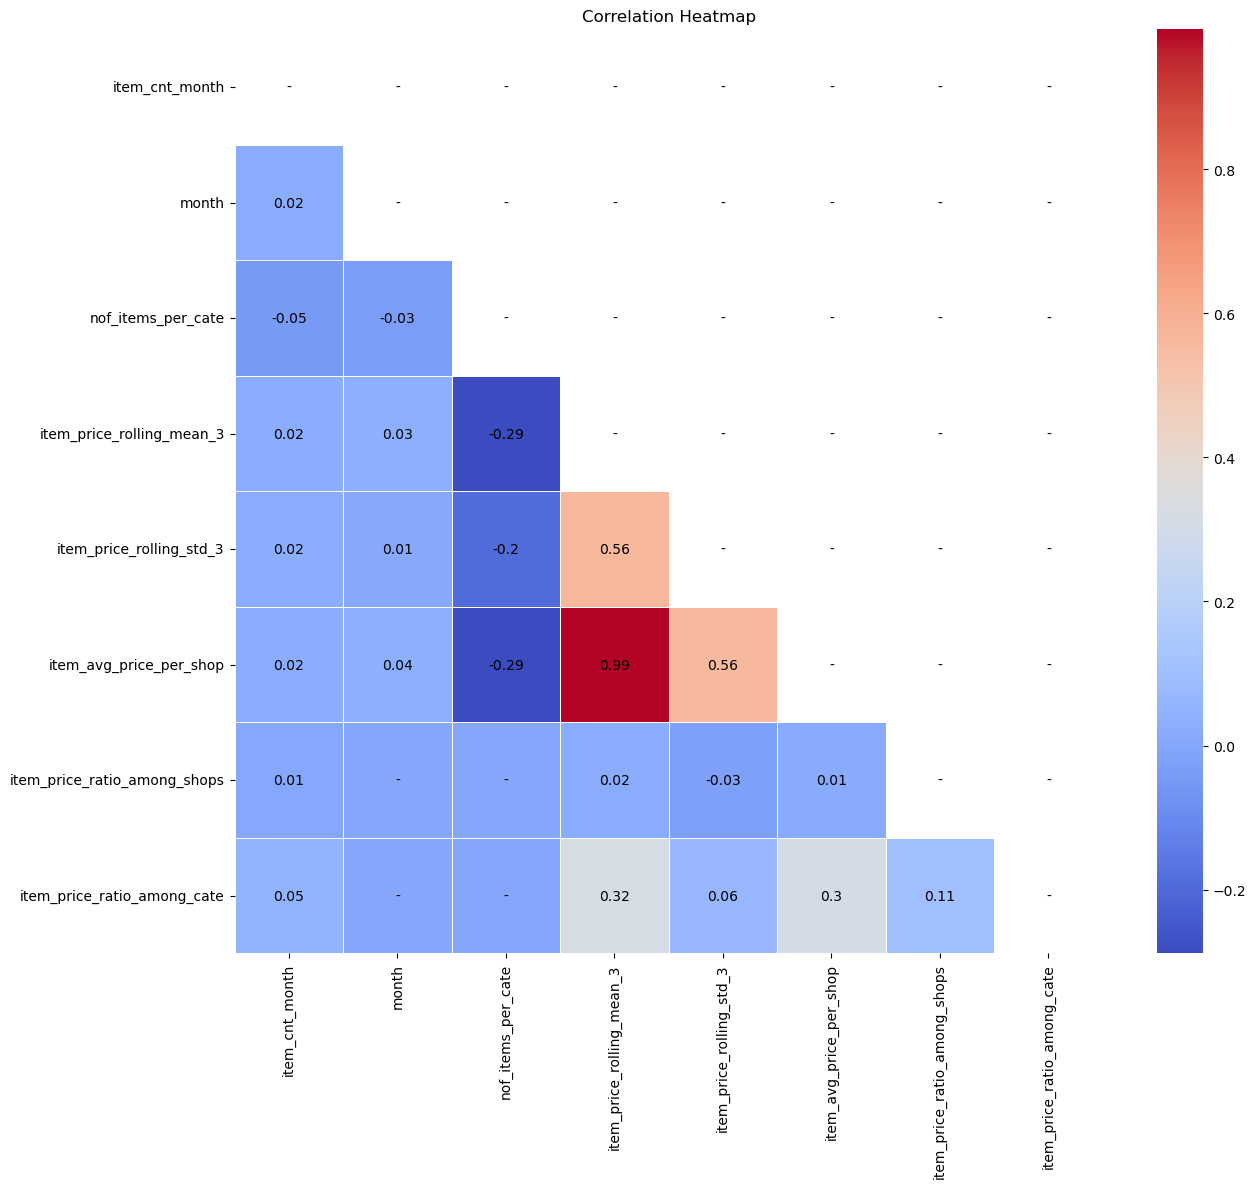

In [60]:
# Plot correlation heatmap
correlation_matrix = df[[target] + features ].corr()
correlation_matrix = correlation_matrix.fillna(0)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
ax = sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', linewidths=.5)
annot = round(correlation_matrix*(~mask),2)
annot.replace(0, '-', inplace=True)
for y in range(annot.shape[0]):
    for x in range(annot.shape[1]):
        plt.text(x + 0.5, y + 0.5, annot.iloc[y, x], 
                 horizontalalignment='center', verticalalignment='center', color='black')
plt.title('Correlation Heatmap')
plt.show()

<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
    <ul>
        <li>
    To mitigate multicollinearity, it's advisable to avoid including both item_avg_price_per_shop and item_price_rolling_mean_3 together. <li>Additionally, none of these features demonstrate strong predictive power with the target variable


# Train model

In [116]:
from sklearn.metrics import mean_absolute_error


In [61]:
# Select features and target
features = [
            'month', 
            'nof_items_per_cate', 
            'item_price_rolling_mean_3',
            'item_price_rolling_std_3',
#             'item_avg_price_per_shop', 
            'item_price_ratio_among_shops',
           'item_price_ratio_among_cate',
           ]
target = 'item_cnt_month'

In [117]:
# Train-test split
X_train = df[df['date_block_num'] < 33][features]
y_train = df[df['date_block_num'] < 33][target]
X_valid = df[df['date_block_num'] == 33][features]
y_valid = df[df['date_block_num'] == 33][target]

# Initialize and train model
model = XGBRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions))
mae = mean_absolute_error(y_train, predictions)
print(f'Train MSE: {rmse}')

print(f'Train MAE: {mae}')

Train MSE: 5.962773333242628
Train MAE: 1.3412824116389161


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
An MAE of 1.3413 and MSE of 5.96 indicates considerable high prediction errors, especially considering that the target variable mostly ranges around 1.
=> Model is slightly underfitting. More features needed
    


In [132]:
predictions = model.predict(X_train)
X_train['prediction'] = predictions

In [133]:
describe.describe_1d_numeric_with_plot(X_train, 'prediction')

stat,value,percentile,value
count,"1,577,593",1%,0.48
non_null,"1,577,593",5%,0.93
null,0.00%,10%,1.04
min,-28.00,20%,1.20
max,"1,240.60",30%,1.28
mode,1.20,40%,1.39
mean,2.27,50%,1.58
tr_mean,2.02,60%,1.83
std,5.52,70%,2.17
mad,1.24,80%,2.68


## Feature importance

In [122]:
importance = model.feature_importances_


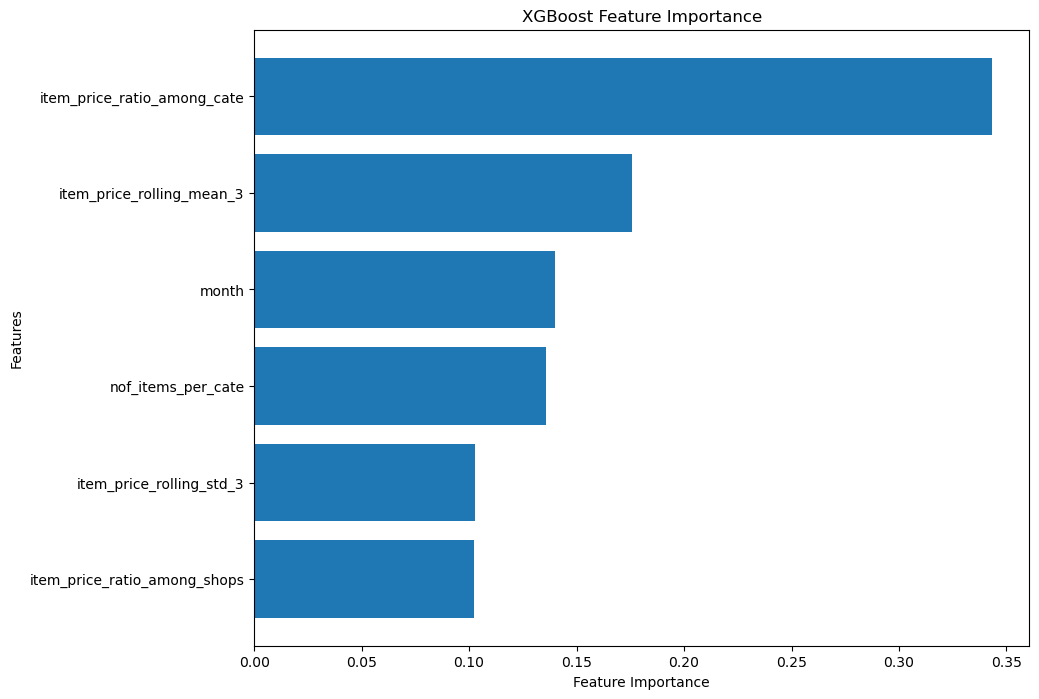

In [124]:
# Get feature names
feature_names = np.array(features)

# Sort the features by importance
sorted_idx = np.argsort(importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

# Evaluate model

## Out of time evaluation

In [129]:
predictions = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, predictions))
mae = mean_absolute_error(y_valid, predictions)

print(f'Validation MSE: {rmse}')
print(f'Validation MAE: {mae}')

Validation MSE: 13.875699597782976
Validation MAE: 1.8640591519377796


## Shap value

In [126]:
import shap


# Create a SHAP explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_valid)


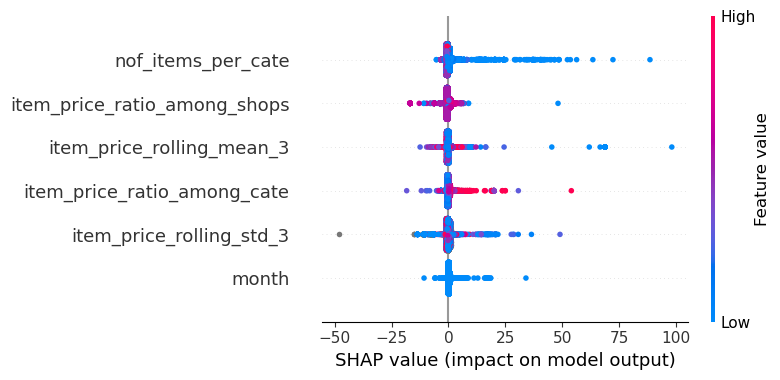

In [128]:
# Summary plot
shap.summary_plot(shap_values, X_valid, feature_names=feature_names)

<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">

<li>Fewer items per category correlate with higher sales quantity (target y), suggesting that less category variety reduces competition and increases the likelihood of item sales.
<li>Shop offer a lower item prices relative to others increase the likelihood of sales.
<li>Conversely, Items priced higher relative to others in the same category are more likely to sell. 
<li>Low and stable price items have high sales 
<li>Sales are typically better at the beginning of the year compared to the end.

## Prediction distribution compare

In [130]:
X_valid['prediction'] = predictions

In [134]:
describe.describe_1d_numeric_with_plot(X_train, 'prediction')

stat,value,percentile,value
count,"1,577,593",1%,0.48
non_null,"1,577,593",5%,0.93
null,0.00%,10%,1.04
min,-28.00,20%,1.20
max,"1,240.60",30%,1.28
mode,1.20,40%,1.39
mean,2.27,50%,1.58
tr_mean,2.02,60%,1.83
std,5.52,70%,2.17
mad,1.24,80%,2.68


In [131]:
describe.describe_1d_numeric_with_plot(X_valid, 'prediction')

stat,value,percentile,value
count,"31,531",1%,0.31
non_null,"31,531",5%,0.82
null,0.00%,10%,1.02
min,-17.93,20%,1.18
max,285.20,30%,1.24
mode,1.23,40%,1.35
mean,2.59,50%,1.58
tr_mean,2.22,60%,1.92
std,5.54,70%,2.25
mad,1.74,80%,2.73


## PSI

In [139]:
for col in features[1:]:
    print(f"PSI of {col}")
    display(hstack_sbs(cal_fine_grain_num(X_train[[col]], X_valid[[col]], col=col, draw=True)))

PSI of nof_items_per_cate


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(1.0,163.0]",163154,4935,0.10,0.16,0.02
1,"(163.0,290.0]",152397,4514,0.10,0.14,0.02
4,"(290.0,397.0]",159111,3014,0.10,0.10,0.00
5,"(397.0,628.0]",217614,4041,0.14,0.13,0.00
6,"(628.0,756.0]",157875,2936,0.10,0.09,0.00
7,"(756.0,1780.0]",152138,3058,0.10,0.10,0.00
2,"(1780.0,2365.0]",243949,4300,0.15,0.14,0.00
3,"(2365.0,5035.0]",331355,4733,0.21,0.15,0.02
Total,,1577593,31531,1.00,1.00,0.06


PSI of item_price_rolling_mean_3


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.09,149.0]",239448,1780,0.15,0.06,0.09
2,"(149.0,199.0]",158179,2159,0.10,0.07,0.01
4,"(199.0,249.0]",84859,2397,0.05,0.08,0.01
5,"(249.0,299.0]",192647,2834,0.12,0.09,0.01
6,"(299.0,399.0]",202049,4135,0.13,0.13,0.00
7,"(399.0,499.0]",90160,2468,0.06,0.08,0.01
8,"(499.0,699.0]",139952,2259,0.09,0.07,0.00
9,"(699.0,1038.4142]",154780,3615,0.10,0.11,0.00
1,"(1038.4142,1799.0]",163657,5112,0.10,0.16,0.03
3,"(1799.0,307980.0]",151862,4772,0.10,0.15,0.02


PSI of item_price_rolling_std_3


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(-0.0,28.2902]",1003853,15210,0.70,0.62,0.01
2,"(28.2902,78.906]",143407,3131,0.10,0.13,0.01
3,"(78.906,182.4323]",143407,2154,0.10,0.09,0.00
1,"(182.4323,8622.1065]",143408,3916,0.10,0.16,0.03
Total,,1434075,24411,1.00,1.00,0.05


PSI of item_price_ratio_among_shops


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.0002,0.9722]",157760,2030,0.10,0.06,0.02
1,"(0.9722,1.0]",650277,19803,0.41,0.63,0.09
2,"(1.0,1.009]",138536,3090,0.09,0.10,0.00
3,"(1.009,1.0181]",157767,2765,0.10,0.09,0.00
4,"(1.0181,1.0289]",157740,1219,0.10,0.04,0.06
5,"(1.0289,1.0521]",157765,1105,0.10,0.04,0.07
6,"(1.0521,23.6759]",157748,1519,0.10,0.05,0.04
Total,,1577593,31531,1.00,1.00,0.27


PSI of item_price_ratio_among_cate


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.0002,0.4167]",157762,3236,0.10,0.10,0.00
1,"(0.4167,0.5967]",157758,3201,0.10,0.10,0.00
2,"(0.5967,0.6788]",159440,3496,0.10,0.11,0.00
3,"(0.6788,0.7354]",156478,1821,0.10,0.06,0.02
4,"(0.7354,0.8694]",157494,3635,0.10,0.12,0.00
5,"(0.8694,1.0295]",158751,3757,0.10,0.12,0.00
6,"(1.0295,1.1371]",156751,2711,0.10,0.09,0.00
7,"(1.1371,1.395]",157653,3494,0.10,0.11,0.00
8,"(1.395,1.7241]",157971,3004,0.10,0.10,0.00
9,"(1.7241,140.4279]",157535,3176,0.10,0.10,0.00


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
<li>
Due to the higher value of the item_price_rolling_mean_3 feature compensate for the lower value of the item_price_ratio_among_shops feature in the validation set compared to the training set, the distribution of predictions in the validation set is nearly the same that of the training set.
<li>However a shift in item_price_rolling_mean_3 the top 2 important feature affect the model power => leading to the huge gape between train and test MSE

# Save model

In [65]:
import joblib

In [66]:
joblib.dump(model, f'model/m1.pkl')

['model/m1.pkl']

# Compute nearest price map

In [207]:
nearest_prices_per_shop = df.groupby(['item_id', 'item_category_id', 'shop_id'])['item_price'].apply(lambda x: x.iloc[(x - x.mean()).abs().argsort()[:1]].values[0]).reset_index()


In [208]:
mean_nearest_prices = nearest_prices_per_shop.groupby(['item_id'])['item_price'].mean().rename('mean_nearest_price').reset_index()

In [209]:
mean_nearest_prices_per_cate = nearest_prices_per_shop.groupby(['item_category_id', 'shop_id'])['item_price'].mean().rename('mean_nearest_price_per_cate').reset_index()

In [265]:
nearest_prices_per_shop.to_csv('data/nearest_prices_per_shop.csv', index=False)
mean_nearest_prices.to_csv('data/mean_nearest_prices.csv',index=False)
mean_nearest_prices_per_cate.to_csv('data/mean_nearest_prices_per_cate.csv',index=False)

# Test model

In [206]:
test = pd.read_csv('test.csv')


In [211]:
test = test.merge(items, how='left')
test = test.merge(nearest_prices_per_shop, how='left')
test = test.merge(mean_nearest_prices, how='left')
test = test.merge(mean_nearest_prices_per_cate, how='left')

In [212]:
test['item_price'] = test['item_price'].fillna(test['mean_nearest_price'])
test['item_price'] = test['item_price'].fillna(test['mean_nearest_price_per_cate'])

In [213]:
test['missing_price'] = False
test.loc[test['item_price'].isnull(), 'missing_price'] = True

In [214]:
describe.describe_1d_category_with_plot(test, 'missing_price')

missing_price,count,frequency (%)
False,"211,971",98.96%
True,"2,229",1.04%
Total,"214,200",100.00%


In [75]:

test['item_price'] = test['item_price'].fillna(300) # based on the item price eda median


In [76]:
test['date_block_num'] = 34
test['month'] = 11

In [77]:
test = test.drop(columns=['mean_nearest_price', 'mean_nearest_price_per_cate', 'missing_price',])

In [78]:
test.shape

(214200, 7)

In [79]:
np.arange(34-3, 34)

array([31, 32, 33])

## Feature for test set

In [80]:
test = test.merge(item_cate)

## among shop

In [81]:
item_price = test.groupby(['item_id', 'date_block_num'])['item_price'].mean().rename('item_avg_price_per_month').reset_index()

In [82]:
test = test.merge(item_price)
test['item_price_ratio_among_shops'] = test['item_price'] / test['item_avg_price_per_month']

In [83]:
test.shape

(214200, 10)

## among cate

In [84]:
cate_price = test.groupby(['item_category_id', 'date_block_num'])['item_price'].mean().rename('cate_avg_price_per_month').reset_index()

In [85]:

test = test.merge(cate_price)
test['item_price_ratio_among_cate'] = test['item_price'] / test['cate_avg_price_per_month']

## rolling price

In [86]:
prev_data = train[train['date_block_num'].isin(np.arange(34-3, 34))].groupby(['date_block_num', 'month', 'shop_id', 'item_id', 'item_category_id']).agg({'item_price': 'mean'}).reset_index()
prev_data = prev_data.rename(columns={'item_cnt_day': 'item_cnt_month'})

In [87]:
test_features = pd.concat([prev_data, test]).reset_index(drop=True)

In [88]:
# Sort by date to ensure the calculation is in chronological order
test_features.sort_values(by='date_block_num', inplace=True)

# Calculate the mean item price over the last three months for each (shop_id, item_id)
test_features['item_price_rolling_mean_3'] = test_features.groupby(['shop_id', 'item_id'])['item_price'].rolling(window=3, min_periods=1).mean().reset_index(level=[0, 1], drop=True)
# 

In [89]:
test_features = test_features.merge(avg_price, how='left')
test_features['item_price_rolling_mean_3'].fillna(test_features['item_avg_price_per_shop'], inplace=True)


In [90]:
test_features['item_price_rolling_std_3'] = test_features.groupby(['shop_id', 'item_id'])['item_price'].rolling(window=3, min_periods=1).std().reset_index(level=[0, 1], drop=True)


test_features = test_features.merge(std_price, how='left')
test_features['item_price_rolling_std_3'].fillna(test_features['item_std_price_per_shop'], inplace=True)


In [91]:
test_features = test_features[test_features['date_block_num'] == 34]

# predict

In [92]:
X_test = test_features[features]

In [93]:
predictions = model.predict(X_test)

In [100]:
test_features['prediction'] = predictions

In [136]:
describe.describe_1d_numeric_with_plot(X_train, 'prediction')

stat,value,percentile,value
count,"1,577,593",1%,0.48
non_null,"1,577,593",5%,0.93
null,0.00%,10%,1.04
min,-28.00,20%,1.20
max,"1,240.60",30%,1.28
mode,1.20,40%,1.39
mean,2.27,50%,1.58
tr_mean,2.02,60%,1.83
std,5.52,70%,2.17
mad,1.24,80%,2.68


In [101]:
describe.describe_1d_numeric_with_plot(test_features, 'prediction')

stat,value,percentile,value
count,"214,200",1%,0.03
non_null,"214,200",5%,0.85
null,0.00%,10%,1.03
min,-24.91,20%,1.16
max,453.55,30%,1.31
mode,1.07,40%,1.51
mean,2.45,50%,1.71
tr_mean,2.03,60%,1.96
std,7.64,70%,2.15
mad,1.51,80%,2.52


## Check PSI

In [137]:
for col in features[1:]:
    print(f"PSI of {col}")
    display(hstack_sbs(cal_fine_grain_num(X_train[[col]], test_features[[col]], col=col, draw=True)))

PSI of nof_items_per_cate


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(1.0,163.0]",163154,26754,0.10,0.12,0.00
1,"(163.0,290.0]",152397,27174,0.10,0.13,0.01
4,"(290.0,397.0]",159111,24990,0.10,0.12,0.00
5,"(397.0,628.0]",217614,26040,0.14,0.12,0.00
6,"(628.0,756.0]",157875,13776,0.10,0.06,0.02
7,"(756.0,1780.0]",152138,34902,0.10,0.16,0.03
2,"(1780.0,2365.0]",243949,28224,0.15,0.13,0.00
3,"(2365.0,5035.0]",331355,32340,0.21,0.15,0.02
Total,,1577593,214200,1.00,1.00,0.09


PSI of item_price_rolling_mean_3


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.09,149.0]",239448,15875,0.15,0.07,0.06
2,"(149.0,199.0]",158179,16679,0.10,0.08,0.01
4,"(199.0,249.0]",84859,17205,0.05,0.08,0.01
5,"(249.0,299.0]",192647,23242,0.12,0.11,0.00
6,"(299.0,399.0]",202049,25915,0.13,0.12,0.00
7,"(399.0,499.0]",90160,14065,0.06,0.07,0.00
8,"(499.0,699.0]",139952,15628,0.09,0.07,0.00
9,"(699.0,1038.4142]",154780,22800,0.10,0.11,0.00
1,"(1038.4142,1799.0]",163657,34679,0.10,0.16,0.03
3,"(1799.0,307980.0]",151862,28112,0.10,0.13,0.01


PSI of item_price_rolling_std_3


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(-0.0,28.2902]",1003853,57782,0.70,0.61,0.01
2,"(28.2902,78.906]",143407,11428,0.10,0.12,0.00
3,"(78.906,182.4323]",143407,10906,0.10,0.11,0.00
1,"(182.4323,8622.1065]",143408,15304,0.10,0.16,0.03
Total,,1434075,95420,1.00,1.00,0.05


PSI of item_price_ratio_among_shops


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.0002,0.9722]",157760,28397,0.10,0.13,0.01
1,"(0.9722,1.0]",650277,92428,0.41,0.43,0.00
2,"(1.0,1.009]",138536,26514,0.09,0.12,0.01
3,"(1.009,1.0181]",157767,22691,0.10,0.11,0.00
4,"(1.0181,1.0289]",157740,10461,0.10,0.05,0.04
5,"(1.0289,1.0521]",157765,10207,0.10,0.05,0.04
6,"(1.0521,23.6759]",157748,23502,0.10,0.11,0.00
Total,,1577593,214200,1.00,1.00,0.10


PSI of item_price_ratio_among_cate


,breakpoint,src_count,des_count,src_perc,des_perc,PSI
0,"(0.0002,0.4167]",157762,19055,0.10,0.09,0.00
1,"(0.4167,0.5967]",157758,22099,0.10,0.10,0.00
2,"(0.5967,0.6788]",159440,26546,0.10,0.12,0.00
3,"(0.6788,0.7354]",156478,7971,0.10,0.04,0.06
4,"(0.7354,0.8694]",157494,22172,0.10,0.10,0.00
5,"(0.8694,1.0295]",158751,46390,0.10,0.22,0.09
6,"(1.0295,1.1371]",156751,12735,0.10,0.06,0.02
7,"(1.1371,1.395]",157653,21411,0.10,0.10,0.00
8,"(1.395,1.7241]",157971,18668,0.10,0.09,0.00
9,"(1.7241,140.4279]",157535,17153,0.10,0.08,0.00


<div style="background-color: #CDF5FD; padding: 10px;  border-radius: 4px;">
<li>
Due to item in test set has higher price and the lower value of the item_price_ratio_among_cate feature, the distribution of predictions in the test set is lower than that of the training set.